# **Regression: image_particle-saa**



Objectives:
* 使用深度神经网络（DNN）解决分类问题.
* 使用卷积神经网络（CNN）解决分类问题.


# **Import Some Packages**

In [18]:
# PyTorch
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# 用于data preprocess
import numpy as np

# 用于 plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm

# 新增包
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from minepy import MINE
import pandas as pd
import pprint as pp
import seaborn as sb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

myseed = 12312  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Data Load

In [19]:
# # 先把保存的数据导入: 
# # feature_list_train_.npy --> train （672，500，27）
# # feature_list_val_.npy --> train （672，3） [image_id, particle_num, saa]
# # image_particle_saa_train.npy --> val （168，500，27）
# # image_particle_saa_val.npy --> val (168, 3)  [image_id, particle_num, saa]

# train
feature_list_train_ = np.load("feature_list_train_.npy")
image_particle_saa_train = np.load("image_particle_saa_train.npy")  # image_id, particle_num, saa
print("feature_list_train_: ", feature_list_train_.shape)
print("image_particle_saa_train: ", image_particle_saa_train.shape)

# val
feature_list_val_ = np.load("feature_list_val_.npy")
image_particle_saa_val = np.load("image_particle_saa_val.npy")  # image_id, particle_num, saa
print("feature_list_val_: ", feature_list_val_.shape)
print("image_particle_saa_val: ", image_particle_saa_val.shape)

feature_list_train_:  (672, 500, 27)
image_particle_saa_train:  (672, 3)
feature_list_val_:  (168, 500, 27)
image_particle_saa_val:  (168, 3)


In [20]:
# # 数据拼接:
# all_data --> data （840，500，27）
# all_label --> label （840，1）
# all_particle_num --> particle_num （840，1）
# all_image_id --> image_id （840，1）
all_data = np.concatenate((feature_list_train_[:, :, :], feature_list_val_[:, :, :]), axis=0)
all_label = np.concatenate((image_particle_saa_train[:, 2], image_particle_saa_val[:, 2]), axis=0).reshape(-1, 1)
all_particle_num = np.concatenate((image_particle_saa_train[:, 1], image_particle_saa_val[:, 1]), axis=0).reshape(-1, 1)
all_image_id = np.concatenate((image_particle_saa_train[:, 0], image_particle_saa_val[:, 0]), axis=0).reshape(-1, 1)
print(all_data.shape)
print(all_label.shape)
print(all_particle_num.shape)
print(all_image_id.shape)
# example:
print("all_data[0][0]: ", all_data[0][0])
print("all_label[0]: ", all_label[0])
print("all_particle_num[0]: ", all_particle_num[0])
print("all_image_id[0]: ", all_image_id[0])
print("all_data[672][0]: ", all_data[672][0])
print("all_label[672]: ", all_label[672])
print("all_particle_num[672]: ", all_particle_num[672])
print("all_image_id[672]: ", all_image_id[672])

(840, 500, 27)
(840, 1)
(840, 1)
(840, 1)
all_data[0][0]:  [390.          76.76955187  23.          25.          22.28370307
   1.11071648   0.975        0.67826087   0.92         0.83156549
   1.          86.375      100.81367925 167.62264151   9.58962264
 129.41745283 167.80660377   9.58018868 127.02830189 100.33254717
 127.57311321 153.97877358 148.82311321 119.08490566 111.71933962
 170.53537736   0.        ]
all_label[0]:  [0.038]
all_particle_num[0]:  [153.]
all_image_id[0]:  [0.]
all_data[672][0]:  [4.99200000e+03 2.89622364e+02 6.70000000e+01 1.05000000e+02
 7.97245998e+01 1.72213586e+00 9.63148756e-01 7.09594883e-01
 6.38095238e-01 7.47859910e-01 1.00000000e+00 6.23279297e+01
 7.96253906e+01 1.49562891e+02 6.11386719e+00 1.51143945e+02
 1.49562891e+02 6.10703125e+00 1.05963281e+02 1.11891992e+02
 1.07260742e+02 1.55595117e+02 1.51587109e+02 9.84814453e+01
 1.09980859e+02 1.72759375e+02 0.00000000e+00]
all_label[672]:  [0.038]
all_particle_num[672]:  [128.]
all_image_id[672]:  

## all_data_mean: image mean use

In [21]:
all_img_mean = np.load('all_img_mean.npy')
print(all_img_mean.shape)
print(all_img_mean[0])
print(all_img_mean[630])


from minepy import MINE
for id_ in range(all_img_mean.shape[1]):
    m = MINE()
    m.compute_score(all_img_mean[:, id_].flatten(), all_img_mean[:, 16].flatten())
#     if m.mic() < 0.3:  # MIC<0.3的特征
    print(id_, m.mic())

(840, 17)
[1.88792413e+02 1.92197574e+02 2.01341906e+02 7.34526224e+01
 3.43448896e+01 2.07378284e+02 7.34013166e+01 1.95247577e+02
 4.85636158e+01 2.00139076e+02 1.31540883e+02 1.31731910e+02
 1.94502670e+02 1.24968538e+02 1.33969668e+02 0.00000000e+00
 3.80000000e-02]
[1.89621505e+02 1.93490665e+02 1.94536804e+02 7.51528025e+01
 3.20011511e+01 2.02766383e+02 7.50979528e+01 1.92397454e+02
 5.12398539e+01 1.99084543e+02 1.28333340e+02 1.30702570e+02
 1.93322297e+02 1.25952060e+02 1.29034698e+02 1.00000000e+00
 4.00000000e-02]
0 0.33327775919471014
1 0.2245434005142471
2 0.41022477682855246
3 0.6460699260946253
4 0.6696046036475615
5 0.2602860012870284
6 0.64431414293589
7 0.15519857172287818
8 0.44000387034056926
9 0.17472205985353453
10 0.7562901552886385
11 0.6363639603835068
12 0.1489259576595895
13 0.6428619251071599
14 0.68932043245787
15 0.7128892850961522
16 0.9988520869152709


## all_data_mean_norm : NN use

In [22]:

all_data_mean = np.zeros((840, 27))
for image_id in range(all_data.shape[0]):
    particle_num = int(all_particle_num[image_id])  # int()
    all_data_mean[image_id] = np.mean(all_data[image_id][0:particle_num][:], axis=0)
# example:
print(all_data_mean.shape)
print(all_data_mean[0])
print(all_data_mean[672])

(840, 27)
[6.92810458e+02 9.49894265e+01 2.90392157e+01 2.89281046e+01
 2.67463213e+01 1.06407875e+00 9.63842941e-01 6.85597103e-01
 1.07174906e+00 7.95324793e-01 1.00000000e+00 7.90593325e+01
 1.06611796e+02 1.73758001e+02 9.83311184e+00 1.41742246e+02
 1.73764808e+02 9.87354840e+00 1.26458746e+02 1.12594640e+02
 1.32545938e+02 1.52363862e+02 1.55246475e+02 1.23479151e+02
 1.05919114e+02 1.72075879e+02 0.00000000e+00]
[678.1953125   94.4047689   28.4609375   29.015625    26.41854758
   1.0964221    0.95880866   0.68071368   1.04986287   0.78945905
   1.          80.80299215 109.58722709 175.26790459   9.84373668
 139.86656293 175.27472798   9.85221707 128.08980567 110.29866239
 134.94554462 151.50425882 155.4696445  125.87419497 105.59165719
 171.30175861   0.        ]


In [23]:

all_data_mean_norm = np.zeros((840, 27))
all_data_mean_norm[:672] = MinMaxScaler().fit_transform(all_data_mean[:672])
all_data_mean_norm[672:] = MinMaxScaler().fit_transform(all_data_mean[672:])
# example:
print(all_data_mean_norm.shape)
print(all_data_mean_norm[0])
print(all_data_mean_norm[672])

(840, 27)
[0.21436769 0.29174585 0.2631363  0.32847052 0.28415028 0.28168966
 0.87386848 0.6962752  0.43151672 0.74402372 1.         0.60116804
 0.66962417 0.96348682 0.02799729 0.93351843 0.96261265 0.02640081
 0.93021202 0.95854254 0.83717942 0.90251433 0.98426334 0.81915305
 0.03387767 0.93579606 0.        ]
[0.18572981 0.2866414  0.26958415 0.32605389 0.27750254 0.26149989
 0.50911569 0.55515151 0.56189678 0.56243005 1.         0.67510156
 0.75947424 1.         0.02517723 0.94337677 1.         0.02324304
 1.         0.96880556 0.91749662 0.88993901 1.         0.90539181
 0.02095841 0.94202275 0.        ]


In [24]:

all_data_mean_norm_label = np.concatenate((all_data_mean_norm, all_label), axis=1)
print(all_data_mean_norm_label.shape)
print(all_data_mean_norm_label[0])
print(all_data_mean_norm_label[672])

(840, 28)
[0.21436769 0.29174585 0.2631363  0.32847052 0.28415028 0.28168966
 0.87386848 0.6962752  0.43151672 0.74402372 1.         0.60116804
 0.66962417 0.96348682 0.02799729 0.93351843 0.96261265 0.02640081
 0.93021202 0.95854254 0.83717942 0.90251433 0.98426334 0.81915305
 0.03387767 0.93579606 0.         0.038     ]
[0.18572981 0.2866414  0.26958415 0.32605389 0.27750254 0.26149989
 0.50911569 0.55515151 0.56189678 0.56243005 1.         0.67510156
 0.75947424 1.         0.02517723 0.94337677 1.         0.02324304
 1.         0.96880556 0.91749662 0.88993901 1.         0.90539181
 0.02095841 0.94202275 0.         0.038     ]


5 0.16516546377621633
6 0.1770016520050261
7 0.2765891679954222
8 0.15790403313585008
9 0.20804406479021756
10 0.036388621072625825


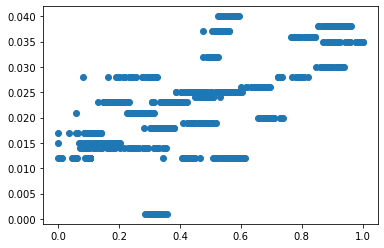

In [25]:

plt.scatter(all_data_mean_norm[:, 25], all_label)

# all Pearson 相关分析
# train_data_df = pd.DataFrame(all_data_mean_norm_label)  # 
# C_mat = train_data_df.corr() 
# # C_mat = train_data_df.corr(method='spearman')  
# # C_mat = train_data_df.corr(method='kendall')  
# fig = plt.figure(figsize = (15,15))
# sb.heatmap(C_mat, vmax = .8, square = True, annot=True)
# plt.show()


for id_ in range(all_data_mean_norm.shape[1]):
    m = MINE()
    m.compute_score(all_data_mean_norm[:, id_].flatten(), all_label.flatten())
    if m.mic() < 0.3:  # MIC<0.3的特征
        print(id_, m.mic())

## all_data_statistics_norm : CNN use

In [26]:

all_data_statistics = np.zeros((840, 20, 27))
all_data_statistics_norm = np.zeros((840, 20, 27))
for image_id in range(all_data.shape[0]):
    particle_num = int(all_particle_num[image_id])  # int()
    all_data_statistics[image_id, 0, :]  = np.mean(all_data[image_id][0:particle_num][:], axis=0)
    all_data_statistics[image_id, 1, :]  = np.percentile(all_data[image_id, 0:particle_num, :],  5, axis=0)
    all_data_statistics[image_id, 2, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 10, axis=0)
    all_data_statistics[image_id, 3, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 15, axis=0)
    all_data_statistics[image_id, 4, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 20, axis=0)
    all_data_statistics[image_id, 5, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 25, axis=0)
    all_data_statistics[image_id, 6, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 30, axis=0)
    all_data_statistics[image_id, 7, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 35, axis=0)
    all_data_statistics[image_id, 8, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 40, axis=0)
    all_data_statistics[image_id, 9, :]  = np.percentile(all_data[image_id, 0:particle_num, :], 45, axis=0)
    all_data_statistics[image_id, 10, :] = np.percentile(all_data[image_id, 0:particle_num, :], 50, axis=0)
    all_data_statistics[image_id, 11, :] = np.percentile(all_data[image_id, 0:particle_num, :], 55, axis=0)
    all_data_statistics[image_id, 12, :] = np.percentile(all_data[image_id, 0:particle_num, :], 60, axis=0)
    all_data_statistics[image_id, 13, :] = np.percentile(all_data[image_id, 0:particle_num, :], 65, axis=0)
    all_data_statistics[image_id, 14, :] = np.percentile(all_data[image_id, 0:particle_num, :], 70, axis=0)
    all_data_statistics[image_id, 15, :] = np.percentile(all_data[image_id, 0:particle_num, :], 75, axis=0)
    all_data_statistics[image_id, 16, :] = np.percentile(all_data[image_id, 0:particle_num, :], 80, axis=0)
    all_data_statistics[image_id, 17, :] = np.percentile(all_data[image_id, 0:particle_num, :], 85, axis=0)
    all_data_statistics[image_id, 18, :] = np.percentile(all_data[image_id, 0:particle_num, :], 90, axis=0)
    all_data_statistics[image_id, 19, :] = np.percentile(all_data[image_id, 0:particle_num, :], 95, axis=0)


for statistics_i in range(20):
    all_data_statistics_norm[:672, statistics_i, :] = MinMaxScaler().fit_transform(all_data_statistics[:672, statistics_i, :])
    all_data_statistics_norm[672:, statistics_i, :] = MinMaxScaler().fit_transform(all_data_statistics[672:, statistics_i, :])
# example:
print(all_data_statistics_norm.shape)
print(all_data_statistics_norm[0][0])
print(all_data_statistics_norm[672][0])

(840, 20, 27)
[0.21436769 0.29174585 0.2631363  0.32847052 0.28415028 0.28168966
 0.87386848 0.6962752  0.43151672 0.74402372 1.         0.60116804
 0.66962417 0.96348682 0.02799729 0.93351843 0.96261265 0.02640081
 0.93021202 0.95854254 0.83717942 0.90251433 0.98426334 0.81915305
 0.03387767 0.93579606 0.        ]
[0.18572981 0.2866414  0.26958415 0.32605389 0.27750254 0.26149989
 0.50911569 0.55515151 0.56189678 0.56243005 1.         0.67510156
 0.75947424 1.         0.02517723 0.94337677 1.         0.02324304
 1.         0.96880556 0.91749662 0.88993901 1.         0.90539181
 0.02095841 0.94202275 0.        ]


5 0.15077283491443425
7 0.29397198099887073
8 0.14296417319633717
9 0.2936078101031675
10 0.0


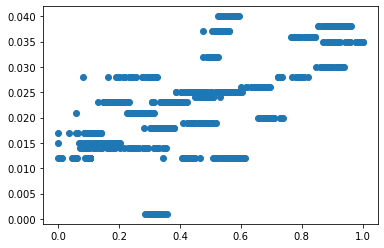

In [27]:

plt.scatter(all_data_statistics_norm[:, 0, 25], all_label)

# train cor
train_data_df = pd.DataFrame(all_data_mean_norm_label)  # 
C_mat = train_data_df.corr()  
# C_mat = train_data_df.corr(method='spearman')  
# C_mat = train_data_df.corr(method='kendall')  
# fig = plt.figure(figsize = (15,15))
# sb.heatmap(C_mat, vmax = .8, square = True, annot=True)
# plt.show()


for id_ in range(all_data_statistics_norm.shape[2]):
    m = MINE()
    m.compute_score(all_data_statistics_norm[:, 8, id_].flatten(), all_label.flatten())
    if m.mic() < 0.3:  # MIC<0.3的特征
        print(id_, m.mic())
#     print(id_, m.mic())

# Image mean

## all_data -> train, val, test

In [92]:


# X = np.concatenate((all_data_mean_norm_label[:, 0:5], all_data_mean_norm_label[:, 11:27]), axis=1).astype(float)
X = all_img_mean[:, 0:15].astype(float)  
# y 乘以25以标准化到1
y = all_img_mean[:, 16].astype(float)
# y = (all_data_mean_norm_label[:, 27]*25).astype(float)
y_ = np.zeros((840,4))
for i in range(y.shape[0]):
    if 0.032<y[i]<=0.040:
        y_[i]=[1,0,0,0]
    elif 0.024<y[i]<=0.032:
        y_[i]=[0,1,0,0]
    elif 0.016<y[i]<=0.024:
        y_[i]=[0,0,1,0]
    elif 0.0<y[i]<=0.016:
        y_[i]=[0,0,0,1]
    else:
        pass

# trainval - test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_, test_size=0.2, stratify=y, random_state=12312)
# trainval - train, val 
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1,
                                                  stratify=y_trainval, random_state=12312)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# # data init
class ClassificationDataset(Dataset): 
    
    def __init__(self, X_data, y_data): 
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): 
        return self.X_data[index], self.y_data[index] 
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = ClassificationDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassificationDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassificationDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

(604, 15) (604, 4)
(68, 15) (68, 4)
(168, 15) (168, 4)


## params

In [94]:
# # params
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = X_train.shape[1]
# # loader
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=1)
test_loader = DataLoader(dataset=test_dataset,batch_size=1)

In [95]:
class MultipleClassification(nn.Module):
    def __init__(self, num_features):
        super(MultipleClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32, 32)
        self.layer_3 = nn.Linear(32, 32)
#         self.layer_4 = nn.Linear(64, 128)
#         self.layer_5 = nn.Linear(128, 64)
#         self.layer_6 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 4)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
#         x = self.relu(self.layer_4(x))
#         x = self.relu(self.layer_5(x))
#         x = self.relu(self.layer_6(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
#         x = self.relu(self.layer_4(x))
#         x = self.relu(self.layer_5(x))
#         x = self.relu(self.layer_6(x))
        x = self.layer_out(x)
        return (x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultipleClassification(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()  
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9,0.99))
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)  
# optimizer = optim.SGD(model.parameters(), lr=0.01)  
loss_stats = {
    'train': [],
    "val": []
}

MultipleClassification(
  (layer_1): Linear(in_features=15, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)


Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.34037869 | Val Loss: 1.80533895
save img_model_final.pkl 1.504234179854393
Epoch 002: | Train Loss: 1.49007834 | Val Loss: 1.50423418
save img_model_final.pkl 1.3781076240188934
Epoch 003: | Train Loss: 1.37217410 | Val Loss: 1.37810762
save img_model_final.pkl 1.3379958447288065
Epoch 004: | Train Loss: 1.35704095 | Val Loss: 1.33799584
save img_model_final.pkl 1.3233753688195173
Epoch 005: | Train Loss: 1.33457546 | Val Loss: 1.32337537
save img_model_final.pkl 1.3011513571528828
Epoch 006: | Train Loss: 1.31452389 | Val Loss: 1.30115136
save img_model_final.pkl 1.2861965403837317
Epoch 007: | Train Loss: 1.28868383 | Val Loss: 1.28619654
save img_model_final.pkl 1.274623098618844
Epoch 008: | Train Loss: 1.27022194 | Val Loss: 1.27462310
save img_model_final.pkl 1.2708958527621101
Epoch 009: | Train Loss: 1.24549631 | Val Loss: 1.27089585
save img_model_final.pkl 1.2416508381857592
Epoch 010: | Train Loss: 1.23970613 | Val Loss: 1.24165084
save img_model_f

Epoch 116: | Train Loss: 0.95357962 | Val Loss: 1.19561871
Epoch 117: | Train Loss: 0.98178477 | Val Loss: 1.12721280
Epoch 118: | Train Loss: 0.98475917 | Val Loss: 1.05495779
Epoch 119: | Train Loss: 0.95791392 | Val Loss: 1.04439893
Epoch 120: | Train Loss: 0.93654053 | Val Loss: 1.03107386
Epoch 121: | Train Loss: 0.95873029 | Val Loss: 1.01708576
Epoch 122: | Train Loss: 0.93177019 | Val Loss: 1.05450393
Epoch 123: | Train Loss: 0.94365987 | Val Loss: 1.03986332
Epoch 124: | Train Loss: 0.97256380 | Val Loss: 1.09054454
Epoch 125: | Train Loss: 0.95665280 | Val Loss: 0.99747742
Epoch 126: | Train Loss: 0.93561984 | Val Loss: 1.06716793
Epoch 127: | Train Loss: 0.97236899 | Val Loss: 1.01937364
Epoch 128: | Train Loss: 0.94164872 | Val Loss: 1.04429849
Epoch 129: | Train Loss: 0.95559013 | Val Loss: 1.06059683
Epoch 130: | Train Loss: 0.95314847 | Val Loss: 1.00973389
save img_model_final.pkl 0.9808093370760188
Epoch 131: | Train Loss: 0.92290747 | Val Loss: 0.98080934
Epoch 132: |

Epoch 247: | Train Loss: 0.87080068 | Val Loss: 0.92199977
Epoch 248: | Train Loss: 0.84468789 | Val Loss: 0.87288647
Epoch 249: | Train Loss: 0.83722162 | Val Loss: 0.92510101
Epoch 250: | Train Loss: 0.86338774 | Val Loss: 0.87440900
Epoch 251: | Train Loss: 0.84442766 | Val Loss: 0.87603592
Epoch 252: | Train Loss: 0.82143182 | Val Loss: 1.00245747
Epoch 253: | Train Loss: 0.91482092 | Val Loss: 0.87042602
save img_model_final.pkl 0.8534870591452893
Epoch 254: | Train Loss: 0.82971900 | Val Loss: 0.85348706
save img_model_final.pkl 0.8437022448462599
Epoch 255: | Train Loss: 0.82733806 | Val Loss: 0.84370224
Epoch 256: | Train Loss: 0.83176853 | Val Loss: 0.87347426
Epoch 257: | Train Loss: 0.86082828 | Val Loss: 0.86614212
Epoch 258: | Train Loss: 0.86103272 | Val Loss: 0.85050486
Epoch 259: | Train Loss: 0.84916354 | Val Loss: 0.94378719
Epoch 260: | Train Loss: 0.90444985 | Val Loss: 0.90258147
Epoch 261: | Train Loss: 0.86728594 | Val Loss: 0.88676432
Epoch 262: | Train Loss: 0.

save img_model_final.pkl 0.7176992422079339
Epoch 380: | Train Loss: 0.73120379 | Val Loss: 0.71769924
Epoch 381: | Train Loss: 0.71272838 | Val Loss: 0.78924767
Epoch 382: | Train Loss: 0.82402689 | Val Loss: 0.90299409
Epoch 383: | Train Loss: 0.78418790 | Val Loss: 0.78872130
Epoch 384: | Train Loss: 0.72698429 | Val Loss: 0.75342978
Epoch 385: | Train Loss: 0.68879239 | Val Loss: 0.77539207
Epoch 386: | Train Loss: 0.71366687 | Val Loss: 0.73062508
Epoch 387: | Train Loss: 0.71835608 | Val Loss: 0.72746009
Epoch 388: | Train Loss: 0.71799412 | Val Loss: 0.75961792
Epoch 389: | Train Loss: 0.71446482 | Val Loss: 0.87863977
Epoch 390: | Train Loss: 0.72092540 | Val Loss: 0.75781630
Epoch 391: | Train Loss: 0.72984291 | Val Loss: 0.73398109
Epoch 392: | Train Loss: 0.72681512 | Val Loss: 0.88121267
Epoch 393: | Train Loss: 0.71540887 | Val Loss: 0.79581174
Epoch 394: | Train Loss: 0.72525340 | Val Loss: 0.80932841
Epoch 395: | Train Loss: 0.69210840 | Val Loss: 0.79052708
Epoch 396: |

Epoch 512: | Train Loss: 0.63859681 | Val Loss: 0.70808671
Epoch 513: | Train Loss: 0.63070675 | Val Loss: 0.70243786
Epoch 514: | Train Loss: 0.59540648 | Val Loss: 0.70683222
Epoch 515: | Train Loss: 0.64134927 | Val Loss: 0.72016919
Epoch 516: | Train Loss: 0.59976689 | Val Loss: 0.66394010
Epoch 517: | Train Loss: 0.63546512 | Val Loss: 0.79723221
Epoch 518: | Train Loss: 0.66086202 | Val Loss: 0.86337899
Epoch 519: | Train Loss: 0.69869990 | Val Loss: 0.68060181
Epoch 520: | Train Loss: 0.70710450 | Val Loss: 0.68344193
Epoch 521: | Train Loss: 0.72430789 | Val Loss: 0.66899737
Epoch 522: | Train Loss: 0.75860308 | Val Loss: 0.77516909
Epoch 523: | Train Loss: 0.65675766 | Val Loss: 0.82160858
Epoch 524: | Train Loss: 0.67297435 | Val Loss: 0.69003095
Epoch 525: | Train Loss: 0.64749802 | Val Loss: 0.70848457
Epoch 526: | Train Loss: 0.64600224 | Val Loss: 0.70152026
save img_model_final.pkl 0.6260433610364357
Epoch 527: | Train Loss: 0.63053133 | Val Loss: 0.62604336
Epoch 528: |

Epoch 647: | Train Loss: 0.79965594 | Val Loss: 0.76114122
Epoch 648: | Train Loss: 0.70286393 | Val Loss: 0.87058494
Epoch 649: | Train Loss: 0.71599516 | Val Loss: 0.65254181
Epoch 650: | Train Loss: 0.61174229 | Val Loss: 0.65509027
Epoch 651: | Train Loss: 0.55013585 | Val Loss: 0.58999692
Epoch 652: | Train Loss: 0.55359013 | Val Loss: 0.59281969
Epoch 653: | Train Loss: 0.54273645 | Val Loss: 0.68095881
Epoch 654: | Train Loss: 0.56252142 | Val Loss: 0.67600766
Epoch 655: | Train Loss: 0.58539929 | Val Loss: 0.84338647
Epoch 656: | Train Loss: 0.78695796 | Val Loss: 0.90828712
Epoch 657: | Train Loss: 0.70063556 | Val Loss: 0.67343630
Epoch 658: | Train Loss: 0.59546071 | Val Loss: 0.68057471
Epoch 659: | Train Loss: 0.57581716 | Val Loss: 0.58098508
Epoch 660: | Train Loss: 0.54686342 | Val Loss: 0.58996257
Epoch 661: | Train Loss: 0.59059293 | Val Loss: 0.63713366
Epoch 662: | Train Loss: 0.57645847 | Val Loss: 0.59201264
Epoch 663: | Train Loss: 0.53488218 | Val Loss: 0.594279

Epoch 782: | Train Loss: 0.55986203 | Val Loss: 0.58885060
Epoch 783: | Train Loss: 0.59074712 | Val Loss: 0.61484574
Epoch 784: | Train Loss: 0.57058369 | Val Loss: 0.61797684
Epoch 785: | Train Loss: 0.53207637 | Val Loss: 0.66293184
Epoch 786: | Train Loss: 0.54807357 | Val Loss: 0.64385207
Epoch 787: | Train Loss: 0.55571711 | Val Loss: 0.54201917
Epoch 788: | Train Loss: 0.51490771 | Val Loss: 0.51848507
Epoch 789: | Train Loss: 0.51288819 | Val Loss: 0.74751750
Epoch 790: | Train Loss: 0.50988102 | Val Loss: 0.53320547
Epoch 791: | Train Loss: 0.48225181 | Val Loss: 0.53203147
Epoch 792: | Train Loss: 0.44822955 | Val Loss: 0.60884246
Epoch 793: | Train Loss: 0.49787174 | Val Loss: 0.61006264
Epoch 794: | Train Loss: 0.56765081 | Val Loss: 0.71091642
Epoch 795: | Train Loss: 0.87317740 | Val Loss: 1.24785537
Epoch 796: | Train Loss: 0.85192763 | Val Loss: 0.77949344
Epoch 797: | Train Loss: 0.73320274 | Val Loss: 0.69876453
Epoch 798: | Train Loss: 0.60904354 | Val Loss: 0.729834

Epoch 918: | Train Loss: 0.45757096 | Val Loss: 0.51031294
Epoch 919: | Train Loss: 0.47443260 | Val Loss: 0.55144698
Epoch 920: | Train Loss: 0.44975401 | Val Loss: 0.55206869
Epoch 921: | Train Loss: 0.47994902 | Val Loss: 0.49655298
Epoch 922: | Train Loss: 0.47429224 | Val Loss: 0.52429496
Epoch 923: | Train Loss: 0.47905917 | Val Loss: 0.57185497
Epoch 924: | Train Loss: 0.48031421 | Val Loss: 0.59034878
Epoch 925: | Train Loss: 0.48385392 | Val Loss: 0.60415898
Epoch 926: | Train Loss: 0.47271162 | Val Loss: 0.50401354
Epoch 927: | Train Loss: 0.47041259 | Val Loss: 0.51623624
Epoch 928: | Train Loss: 0.45347669 | Val Loss: 0.52982111
Epoch 929: | Train Loss: 0.46942613 | Val Loss: 0.55597631
Epoch 930: | Train Loss: 0.48239759 | Val Loss: 0.56484249
Epoch 931: | Train Loss: 0.50260003 | Val Loss: 0.66053782
Epoch 932: | Train Loss: 0.46091472 | Val Loss: 0.63277702
Epoch 933: | Train Loss: 0.50647586 | Val Loss: 0.55374229
Epoch 934: | Train Loss: 0.53599265 | Val Loss: 0.514632

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

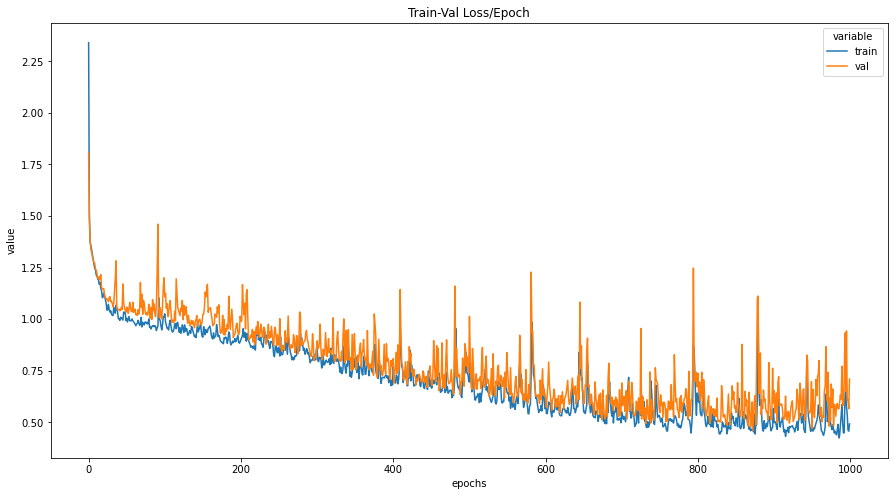

In [96]:
print("Begin training.")
best_val_loss = float('inf')
for e in tqdm(range(1, EPOCHS+1)): 
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, torch.max(y_train_batch, 1)[1])
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, torch.max(y_val_batch, 1)[1])
            val_epoch_loss += val_loss.item()
    
    if e > 1:
        if best_val_loss > val_epoch_loss/len(val_loader):
            best_val_loss = val_epoch_loss/len(val_loader)
            torch.save(model.state_dict(), 'img_model_final.pkl')
            print('save img_model_final.pkl', val_epoch_loss/len(val_loader))

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.8f} | Val Loss: {val_epoch_loss/len(val_loader):.8f}')
    
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sb.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

## prediction

(168, 1)
(168, 1)
GT     predict
[[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 2.]
 [1. 2.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 2.]
 [1. 1.]
 [1. 1.]
 [1. 2.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 2.]
 [2. 1.]
 [2. 2.]
 [2. 2.]
 [2. 1.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 3.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 1.]
 [2. 1.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 1.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [2.

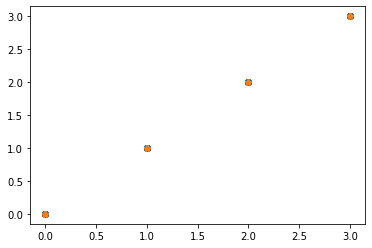

In [99]:
model.load_state_dict(torch.load('img_model_final.pkl'))
# model.load_state_dict(torch.load('img_model_final0833.pkl'))
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(torch.max(y_test_pred, 1)[1])

# predictions
predictions = np.array(y_pred_list).reshape(-1, 1)
print(predictions.shape)

gt = np.argmax(y_test.reshape(-1, 4), axis=1).reshape(-1,1)
print(gt.shape)

# gt_pred
gt_pred = np.concatenate((gt.astype(float), predictions.astype(float)), axis=1)
gt_pred_sort = gt_pred[np.argsort(gt_pred[:,0])]
print("GT     predict")
print(gt_pred_sort)

plt.scatter(gt_pred_sort[:, 0], gt_pred_sort[:, 0], marker='o')
plt.scatter(gt_pred_sort[:, 1], gt_pred_sort[:, 1], marker='*')

In [100]:
gt_ = np.zeros((gt_pred_sort.shape[0], 4))
pred_ = np.zeros((gt_pred_sort.shape[0], 4))
for i in range(gt_pred_sort.shape[0]):
    if gt_pred_sort[i,0]==0:
        gt_[i] = [1,0,0,0]
    elif gt_pred_sort[i,0]==1:
        gt_[i] = [0,1,0,0]
    elif gt_pred_sort[i,0]==2:
        gt_[i] = [0,0,1,0]
    elif gt_pred_sort[i,0]==3:
        gt_[i] = [0,0,0,1]
    else:
        pass
    if gt_pred_sort[i,1]==0:
        pred_[i] = [1,0,0,0]
    elif gt_pred_sort[i,1]==1:
        pred_[i] = [0,1,0,0]
    elif gt_pred_sort[i,1]==2:
        pred_[i] = [0,0,1,0]
    elif gt_pred_sort[i,1]==3:
        pred_[i] = [0,0,0,1]
    else:
        pass
print(gt_.shape)
print(pred_.shape)

from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

ham_distance = hamming_loss(gt_,pred_)
accuracy = accuracy_score(gt_,pred_)
precision = precision_score(gt_,pred_,average='micro')
recall = recall_score(gt_,pred_,average='micro')
f1 = f1_score(gt_,pred_,average='micro')

print("ham_distance: ", ham_distance)
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

(168, 4)
(168, 4)
ham_distance:  0.08333333333333333
accuracy:  0.8333333333333334
precision:  0.8333333333333334
recall:  0.8333333333333334
f1:  0.8333333333333334


# NN

## all_data -> train, val, test

In [60]:
# # all_data_mean_norm_label --> X, y
X = np.concatenate((all_data_mean_norm_label[:, 0:5], all_data_mean_norm_label[:, 11:27]), axis=1).astype(float)
# X = all_data_mean_norm_label[:, 0:27].astype(float)  
# y 乘以25以标准化到1
y = all_data_mean_norm_label[:, 27].astype(float)
# y = (all_data_mean_norm_label[:, 27]*25).astype(float)
y_ = np.zeros((840,4))
for i in range(y.shape[0]):
    if 0.032<y[i]<=0.040:
        y_[i]=[1,0,0,0]
    elif 0.024<y[i]<=0.032:
        y_[i]=[0,1,0,0]
    elif 0.016<y[i]<=0.024:
        y_[i]=[0,0,1,0]
    elif 0.0<y[i]<=0.016:
        y_[i]=[0,0,0,1]
    else:
        pass

# trainval - test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_, test_size=0.2, stratify=y, random_state=12312)
# trainval - train, val 
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1,
                                                  stratify=y_trainval, random_state=12312)

# # trainval - test
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_, test_size=0.2, stratify=y)
# # trainval - train, val 
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1,
#                                                   stratify=y_trainval)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# # data init
class ClassificationDataset(Dataset): 
    
    def __init__(self, X_data, y_data): 
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): 
        return self.X_data[index], self.y_data[index] 
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = ClassificationDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassificationDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassificationDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

(604, 21) (604, 4)
(68, 21) (68, 4)
(168, 21) (168, 4)


## params

In [70]:
# # params
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.005
NUM_FEATURES = X_train.shape[1]
# # loader
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=1)
test_loader = DataLoader(dataset=test_dataset,batch_size=1)

## NN

In [71]:
class MultipleClassification(nn.Module):
    def __init__(self, num_features):
        super(MultipleClassification, self).__init__()

        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32, 32)
        self.layer_3 = nn.Linear(32, 32)
#         self.layer_4 = nn.Linear(64, 128)
#         self.layer_5 = nn.Linear(128, 64)
#         self.layer_6 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 4)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
#         x = self.relu(self.layer_4(x))
#         x = self.relu(self.layer_5(x))
#         x = self.relu(self.layer_6(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
#         x = self.relu(self.layer_4(x))
#         x = self.relu(self.layer_5(x))
#         x = self.relu(self.layer_6(x))
        x = self.layer_out(x)
        return (x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultipleClassification(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()  
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9,0.99))
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)  
# optimizer = optim.SGD(model.parameters(), lr=0.01)  
loss_stats = {
    'train': [],
    "val": []
}

MultipleClassification(
  (layer_1): Linear(in_features=21, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)


Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.36657836 | Val Loss: 1.33720989
save model_final.pkl 1.2309891143265892
Epoch 002: | Train Loss: 1.29322656 | Val Loss: 1.23098911
save model_final.pkl 1.0963916831156786
Epoch 003: | Train Loss: 1.15796441 | Val Loss: 1.09639168
save model_final.pkl 1.0276111127699123
Epoch 004: | Train Loss: 1.04990944 | Val Loss: 1.02761111
save model_final.pkl 0.9656070990159231
Epoch 005: | Train Loss: 0.98222145 | Val Loss: 0.96560710
Epoch 006: | Train Loss: 0.93922356 | Val Loss: 1.00855451
save model_final.pkl 0.8789533810580478
Epoch 007: | Train Loss: 0.90820836 | Val Loss: 0.87895338
save model_final.pkl 0.8240779820172226
Epoch 008: | Train Loss: 0.86007093 | Val Loss: 0.82407798
save model_final.pkl 0.817444421350956
Epoch 009: | Train Loss: 0.84409024 | Val Loss: 0.81744442
Epoch 010: | Train Loss: 0.80903561 | Val Loss: 0.86863886
save model_final.pkl 0.7810519626911949
Epoch 011: | Train Loss: 0.80752115 | Val Loss: 0.78105196
save model_final.pkl 0.780531034

Epoch 118: | Train Loss: 0.33720501 | Val Loss: 0.43956085
Epoch 119: | Train Loss: 0.31278162 | Val Loss: 0.34476416
Epoch 120: | Train Loss: 0.32488837 | Val Loss: 0.33094167
Epoch 121: | Train Loss: 0.29561753 | Val Loss: 0.35443310
Epoch 122: | Train Loss: 0.33255436 | Val Loss: 0.44007046
Epoch 123: | Train Loss: 0.35048747 | Val Loss: 0.39414993
Epoch 124: | Train Loss: 0.36168056 | Val Loss: 0.37669643
Epoch 125: | Train Loss: 0.35466407 | Val Loss: 0.33336598
save model_final.pkl 0.2925466864296194
Epoch 126: | Train Loss: 0.30339658 | Val Loss: 0.29254669
save model_final.pkl 0.2761185944907672
Epoch 127: | Train Loss: 0.31899523 | Val Loss: 0.27611859
Epoch 128: | Train Loss: 0.29922115 | Val Loss: 0.36521059
Epoch 129: | Train Loss: 0.33005195 | Val Loss: 0.45047033
Epoch 130: | Train Loss: 0.32547016 | Val Loss: 0.32401989
Epoch 131: | Train Loss: 0.30700675 | Val Loss: 0.31152311
Epoch 132: | Train Loss: 0.29727459 | Val Loss: 0.36814861
Epoch 133: | Train Loss: 0.30393325

Epoch 253: | Train Loss: 0.18165118 | Val Loss: 0.27748886
Epoch 254: | Train Loss: 0.16235836 | Val Loss: 0.31466005
Epoch 255: | Train Loss: 0.19017987 | Val Loss: 0.28185533
Epoch 256: | Train Loss: 0.19252607 | Val Loss: 0.38715311
Epoch 257: | Train Loss: 0.16346862 | Val Loss: 0.32998832
Epoch 258: | Train Loss: 0.20635008 | Val Loss: 0.30082767
Epoch 259: | Train Loss: 0.17791931 | Val Loss: 0.27671347
Epoch 260: | Train Loss: 0.18079505 | Val Loss: 0.27032547
Epoch 261: | Train Loss: 0.16618699 | Val Loss: 0.36918318
Epoch 262: | Train Loss: 0.16472362 | Val Loss: 0.26685583
save model_final.pkl 0.23627739700779168
Epoch 263: | Train Loss: 0.14021528 | Val Loss: 0.23627740
Epoch 264: | Train Loss: 0.16101760 | Val Loss: 0.37080311
Epoch 265: | Train Loss: 0.19366517 | Val Loss: 0.40276470
Epoch 266: | Train Loss: 0.15208217 | Val Loss: 0.24976461
Epoch 267: | Train Loss: 0.15502738 | Val Loss: 0.43352026
Epoch 268: | Train Loss: 0.17454812 | Val Loss: 0.26561152
Epoch 269: | Tr

Epoch 392: | Train Loss: 0.16013786 | Val Loss: 0.32275307
Epoch 393: | Train Loss: 0.20918661 | Val Loss: 0.44557115
Epoch 394: | Train Loss: 0.19423295 | Val Loss: 0.29542770
Epoch 395: | Train Loss: 0.12425203 | Val Loss: 0.28664472
Epoch 396: | Train Loss: 0.11873786 | Val Loss: 0.30760535
Epoch 397: | Train Loss: 0.10823157 | Val Loss: 0.26483893
Epoch 398: | Train Loss: 0.11508392 | Val Loss: 0.28823888
Epoch 399: | Train Loss: 0.11248501 | Val Loss: 0.40676566
Epoch 400: | Train Loss: 0.12344355 | Val Loss: 0.26745141
Epoch 401: | Train Loss: 0.10620297 | Val Loss: 0.26688064
Epoch 402: | Train Loss: 0.11352819 | Val Loss: 0.24404970
Epoch 403: | Train Loss: 0.12590412 | Val Loss: 0.40770282
Epoch 404: | Train Loss: 0.16219916 | Val Loss: 0.34301986
Epoch 405: | Train Loss: 0.13873979 | Val Loss: 0.34452124
Epoch 406: | Train Loss: 0.15309156 | Val Loss: 0.23937933
Epoch 407: | Train Loss: 0.13734215 | Val Loss: 0.33357830
Epoch 408: | Train Loss: 0.17215284 | Val Loss: 0.359511

Epoch 531: | Train Loss: 0.08583718 | Val Loss: 0.23041910
Epoch 532: | Train Loss: 0.10397852 | Val Loss: 0.29550579
Epoch 533: | Train Loss: 0.08030443 | Val Loss: 0.27411315
Epoch 534: | Train Loss: 0.07689628 | Val Loss: 0.30049495
Epoch 535: | Train Loss: 0.10299328 | Val Loss: 0.25359287
Epoch 536: | Train Loss: 0.13810541 | Val Loss: 0.35030827
Epoch 537: | Train Loss: 0.18629862 | Val Loss: 0.42485865
Epoch 538: | Train Loss: 0.14896452 | Val Loss: 0.57429011
Epoch 539: | Train Loss: 0.19869032 | Val Loss: 0.32489116
Epoch 540: | Train Loss: 0.11624701 | Val Loss: 0.31100367
Epoch 541: | Train Loss: 0.11809622 | Val Loss: 0.29132783
Epoch 542: | Train Loss: 0.10093110 | Val Loss: 0.35472056
Epoch 543: | Train Loss: 0.09138031 | Val Loss: 0.35390867
Epoch 544: | Train Loss: 0.13570114 | Val Loss: 0.45917181
Epoch 545: | Train Loss: 0.10195198 | Val Loss: 0.24468549
Epoch 546: | Train Loss: 0.08154510 | Val Loss: 0.29361619
Epoch 547: | Train Loss: 0.07791439 | Val Loss: 0.273946

Epoch 671: | Train Loss: 0.09276597 | Val Loss: 0.37853805
Epoch 672: | Train Loss: 0.09826245 | Val Loss: 0.26759601
Epoch 673: | Train Loss: 0.08831649 | Val Loss: 0.23476508
Epoch 674: | Train Loss: 0.08072205 | Val Loss: 0.38098181
Epoch 675: | Train Loss: 0.08955399 | Val Loss: 0.35225712
Epoch 676: | Train Loss: 0.10346470 | Val Loss: 0.28720911
Epoch 677: | Train Loss: 0.06252402 | Val Loss: 0.28176034
Epoch 678: | Train Loss: 0.06661291 | Val Loss: 0.28916028
Epoch 679: | Train Loss: 0.06509622 | Val Loss: 0.30898224
Epoch 680: | Train Loss: 0.06780602 | Val Loss: 0.24996820
Epoch 681: | Train Loss: 0.07121411 | Val Loss: 0.29253519
Epoch 682: | Train Loss: 0.06882063 | Val Loss: 0.28734015
Epoch 683: | Train Loss: 0.06872029 | Val Loss: 0.25827734
Epoch 684: | Train Loss: 0.07971300 | Val Loss: 0.32143354
Epoch 685: | Train Loss: 0.05882331 | Val Loss: 0.30705344
Epoch 686: | Train Loss: 0.06194873 | Val Loss: 0.23149584
Epoch 687: | Train Loss: 0.06642457 | Val Loss: 0.304642

Epoch 810: | Train Loss: 0.07092563 | Val Loss: 0.36000983
Epoch 811: | Train Loss: 0.07447444 | Val Loss: 0.25838035
Epoch 812: | Train Loss: 0.08556792 | Val Loss: 0.42766388
Epoch 813: | Train Loss: 0.07939463 | Val Loss: 0.35031554
Epoch 814: | Train Loss: 0.10272811 | Val Loss: 0.41475136
Epoch 815: | Train Loss: 0.11026482 | Val Loss: 0.32662396
Epoch 816: | Train Loss: 0.13205500 | Val Loss: 0.32510370
Epoch 817: | Train Loss: 0.12919911 | Val Loss: 0.27406879
Epoch 818: | Train Loss: 0.08796354 | Val Loss: 0.43590348
Epoch 819: | Train Loss: 0.07485230 | Val Loss: 0.41613776
Epoch 820: | Train Loss: 0.07086223 | Val Loss: 0.32814087
Epoch 821: | Train Loss: 0.06680014 | Val Loss: 0.31498770
Epoch 822: | Train Loss: 0.07685933 | Val Loss: 0.31055267
Epoch 823: | Train Loss: 0.08925800 | Val Loss: 0.46378356
Epoch 824: | Train Loss: 0.07974082 | Val Loss: 0.33169774
Epoch 825: | Train Loss: 0.06665193 | Val Loss: 0.49556666
Epoch 826: | Train Loss: 0.08039866 | Val Loss: 0.347212

Epoch 950: | Train Loss: 0.04115323 | Val Loss: 0.24296037
Epoch 951: | Train Loss: 0.03935647 | Val Loss: 0.23227047
Epoch 952: | Train Loss: 0.04662131 | Val Loss: 0.23836979
Epoch 953: | Train Loss: 0.05824980 | Val Loss: 0.25053446
Epoch 954: | Train Loss: 0.04762698 | Val Loss: 0.24634578
Epoch 955: | Train Loss: 0.04762210 | Val Loss: 0.26337282
Epoch 956: | Train Loss: 0.05335758 | Val Loss: 0.36169374
Epoch 957: | Train Loss: 0.06360588 | Val Loss: 0.30633510
Epoch 958: | Train Loss: 0.05721320 | Val Loss: 0.27213165
Epoch 959: | Train Loss: 0.06553846 | Val Loss: 0.30348198
Epoch 960: | Train Loss: 0.08297082 | Val Loss: 0.25113339
Epoch 961: | Train Loss: 0.06431979 | Val Loss: 0.34333132
Epoch 962: | Train Loss: 0.05243620 | Val Loss: 0.27601368
Epoch 963: | Train Loss: 0.03701421 | Val Loss: 0.30168140
Epoch 964: | Train Loss: 0.04020340 | Val Loss: 0.24507972
Epoch 965: | Train Loss: 0.03595281 | Val Loss: 0.28981569
Epoch 966: | Train Loss: 0.03698724 | Val Loss: 0.258123

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

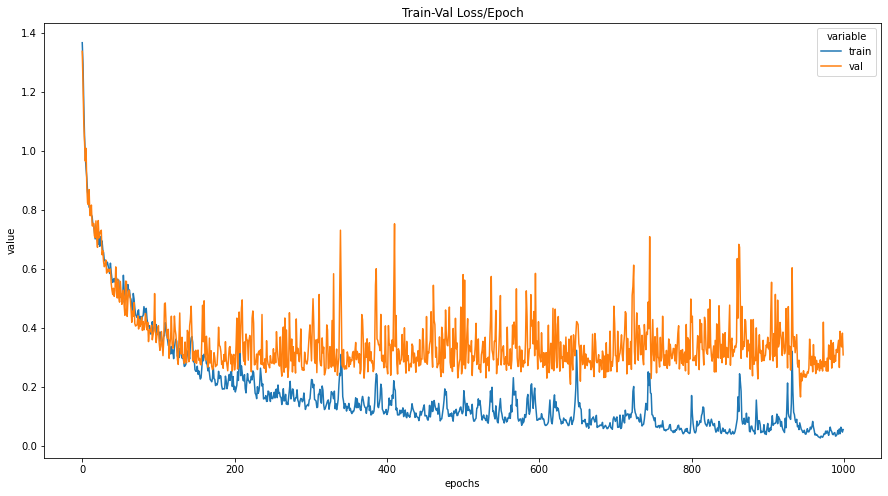

In [72]:
print("Begin training.")
best_val_loss = float('inf')
for e in tqdm(range(1, EPOCHS+1)): 
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, torch.max(y_train_batch, 1)[1])
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, torch.max(y_val_batch, 1)[1])
            val_epoch_loss += val_loss.item()
    
    if e > 1:
        if best_val_loss > val_epoch_loss/len(val_loader):
            best_val_loss = val_epoch_loss/len(val_loader)
            torch.save(model.state_dict(), 'model_final.pkl')
            print('save model_final.pkl', val_epoch_loss/len(val_loader))

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.8f} | Val Loss: {val_epoch_loss/len(val_loader):.8f}')
    
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sb.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')